# Boise River Trend Analysis
### CAVEAT: This analysis is only analyzing the last 45 water years.
- Date range for data is 1972 through 2017
- The data is first assessed for stationarity using the Dickey-Fuller test statistics
- Each data component histogram indicates whether the data is parametric or nonparametric
- A Moving Average model was used to evaluate the mean of each component of the series, using a 1 year centered window
- Each data component will be evaluated using one of two trend analysis tests depending on if the data is parametric.
    - Parametric data will be assessed using a linear regression to determine trend significance
    - Nonparametric data will be assessed using the Mann-Kendall test to determine trend significance

## Trendline statistics information
Statistical analysis can be completed on trendlines to assess actual trend using the Mann-Kendall(M.K) trend test. The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically assess if there is a monotonic upward or downward trend of the variable of interest over time. A monotonic upward (downward) trend means that the variable consistently increases (decreases) through time, but the trend may or may not be linear. 
The MK test can be used in place of a parametric linear regression analysis, which can be used to test if the slope of the estimated linear regression line is different from zero. The regression analysis requires that the residuals from the fitted regression line be normally distributed; an assumption not required by the MK test, that is, the MK test is a non-parametric (distribution-free) test. Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best viewed as an exploratory analysis.
This method is the same used in:
- Clark, Gregory M., 2010. Changes in Patterns of Streamflow From Unregulated Watersheds in Idaho, Western Wyoming, and Northern Nevada. Journal of the American Water Resources Association

## Initialize

In [90]:
from __future__ import division
from scipy.stats import norm, mstats
import pandas as pd
import numpy as np
from scipy.special import ndtri, ndtr
import sys
import math
import statistics
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import close
from pandas.core import datetools as dt
import statsmodels.tsa.api as sm
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# read in and initialize
df = pd.read_csv('boiseriverDischarge.csv', names=['Dates','Year','Month','Day','Parma','Lucky'], skiprows=1)
df2 = pd.read_csv('boiseriverTemp.csv', names=['YEAR','TEMP'], skiprows=1)
parma = df['Parma'].values
lucky = df['Lucky'].values
df['Date'] = pd.to_datetime(df.Year*10000+df.Month*100+df.Day,format='%Y%m%d')
dates = df['Date']
tempValues = df2['TEMP'].values
tempYear = df2['YEAR'].values
seriesTemp = pd.Series(tempValues,tempYear)

# create series data from values
seriesLucky = pd.Series(lucky,index=dates)
seriesParma = pd.Series(parma,index=dates)
# Year window of interest
N = 1
# Decomposition of the data based on N years
years = N*365
# Decomposition of the data based on N years
decompositionLucky = sm.seasonal_decompose(seriesLucky, model='additive',freq=years)
decompositionParma = sm.seasonal_decompose(seriesParma, model='additive',freq=years)
# Year window of interest
N = 1
# Decomposition of the data based on N years
years = N*365

# Mann-Kendall function
def test(t, x, eps=None, alpha=None, Ha=None):
    """
    Runs the Mann-Kendall test for trend in time series data.

    Parameters
    ----------
    t : 1D numpy.ndarray
        array of the time points of measurements
    x : 1D numpy.ndarray
        array containing the measurements corresponding to entries of 't'
    eps : scalar, float, greater than zero
        least count error of measurements which help determine ties in the data
    alpha : scalar, float, greater than zero
        significance level of the statistical test (Type I error)
    Ha : string, options include 'up', 'down', 'upordown'
        type of test: one-sided ('up' or 'down') or two-sided ('updown')

    Returns
    -------
    MK : string
        result of the statistical test indicating whether or not to accept hte
        alternative hypothesis 'Ha'
    m : scalar, float
        slope of the linear fit to the data
    c : scalar, float
        intercept of the linear fit to the data
    p : scalar, float, greater than zero
        p-value of the obtained Z-score statistic for the Mann-Kendall test

    Raises
    ------
    AssertionError : error
                    least count error of measurements 'eps' is not given
    AssertionError : error
                    significance level of test 'alpha' is not given
    AssertionError : error
                    alternative hypothesis 'Ha' is not given

    """
    # assert a least count for the measurements x
    assert eps, "Please provide least count error for measurements 'x'"
    assert alpha, "Please provide significance level 'alpha' for the test"
    assert Ha, "Please provide the alternative hypothesis 'Ha'"
    # estimate sign of all possible (n(n-1)) / 2 differences
    n = len(t)
    sgn = np.zeros((n, n), dtype="int")
    for i in range(n):
        tmp = x - x[i]
        tmp[np.where(np.fabs(tmp) <= eps)] = 0.
        sgn[i] = np.sign(tmp)
    # estimate mean of the sign of all possible differences
    S = sgn[np.triu_indices(n, k=1)].sum()
    # estimate variance of the sign of all possible differences
    # 1. Determine no. of tie groups 'p' and no. of ties in each group 'q'
    np.fill_diagonal(sgn, eps * 1E6)
    i, j = np.where(sgn == 0.)
    ties = np.unique(x[i])
    p = len(ties)
    q = np.zeros(len(ties), dtype="int")
    for k in range(p):
        idx =  np.where(np.fabs(x - ties[k]) < eps)[0]
        q[k] = len(idx)
    # 2. Determine the two terms in the variance calculation
    term1 = n * (n - 1.) * (2. * n + 5.)
    term2 = (q * (q - 1.) * (2. * q + 5.)).sum()
    # 3. estimate variance
    varS = float(term1 - term2) / 18.
    # Compute the Z-score based on above estimated mean and variance
    if S > eps:
        Zmk = (S - 1.) / np.sqrt(varS)
    elif np.fabs(S) <= eps:
        Zmk = 0.
    elif S < -eps:
        Zmk = (S + 1.) / np.sqrt(varS)
    # compute test based on given 'alpha' and alternative hypothesis
    # note: for all the following cases, the null hypothesis Ho is:
    # Ho := there is no monotonic trend
    # 
    # Ha := There is an upward monotonic trend
    if Ha == "up":
        Z_ = ndtri(1. - alpha)
        if Zmk >= Z_:
            MK = "Upward trend"
        else:
            MK = "Upward trend"
    # Ha := There is a downward monotonic trend
    elif Ha == "down":
        Z_ = ndtri(1. - alpha)
        if Zmk <= -Z_:
            MK = "Downward trend"
        else:
            MK = "Downward trend"
    # Ha := There is an upward OR downward monotonic trend
    elif Ha == "upordown":
        Z_ = ndtri(1. - alpha / 2.)
        if np.fabs(Zmk) >= Z_:
            MK = "upward OR downward trend"
        else:
            MK = "upward OR downward trend"
    # estimate the slope and intercept of the line
    m = np.corrcoef(t, x)[0, 1] * (np.std(x) / np.std(t))
    c = np.mean(x) - m * np.mean(t)
    # estimate the p-value for the obtained Z-score Zmk
    if S > eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (1. - ndtr(Zmk))
    elif np.fabs(S) <= eps:
        p = 0.5
    elif S < -eps:
        if Ha == "up":
            p = 1. - ndtr(Zmk)
        elif Ha == "down":
            p = ndtr(Zmk)
        elif Ha == "upordown":
            p = 0.5 * (ndtr(Zmk))     
    # confidence level
    alpha = alpha
    con = (1 - alpha)

    return MK, m, c, p, alpha, Ha, con

# Confidence Interval function
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

## Lucky Peak and Parma
- Dickey-Fuller test
- Decomposition
- Moving Average
- Trend Analysis

In [47]:
# Lucky Peak Dickey Fuller test
print ('Results of Dickey-Fuller Test for Lucky Peak Discharge:')
dftest = adfuller(seriesLucky, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
# Parma Dickey Fuller test
print ('Results of Dickey-Fuller Test for Parma Discharge:')
dftest = adfuller(seriesParma, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
print(' \033[1m The Test Statistic is less than all critical values; the p-value is less than 0.05; the data is considered stationary \033[1m')

Results of Dickey-Fuller Test for Lucky Peak Discharge:
Test Statistic                -1.257271e+01
p-value                        1.987961e-23
#Lags Used                     4.300000e+01
Number of Observations Used    1.675800e+04
Critical Value (1%)           -3.430740e+00
Critical Value (5%)           -2.861712e+00
Critical Value (10%)          -2.566862e+00
dtype: float64
Results of Dickey-Fuller Test for Parma Discharge:
Test Statistic                -1.015807e+01
p-value                        7.635790e-18
#Lags Used                     3.800000e+01
Number of Observations Used    1.676300e+04
Critical Value (1%)           -3.430740e+00
Critical Value (5%)           -2.861712e+00
Critical Value (10%)          -2.566862e+00
dtype: float64
  The Test Statistic is less than all critical values; the p-value is less than 0.05; the data is considered stationary 


Decomposition of Lucky Peak Discharge


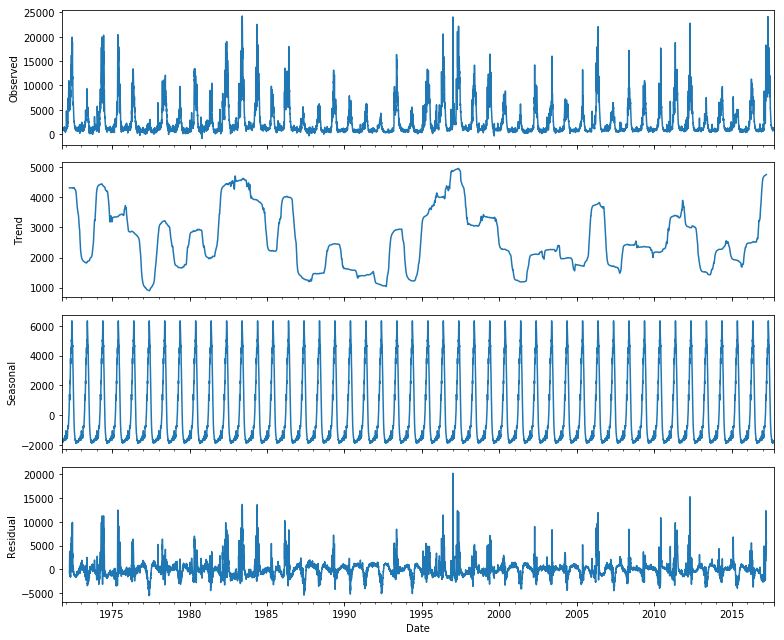

Decomposition of Parma Discharge


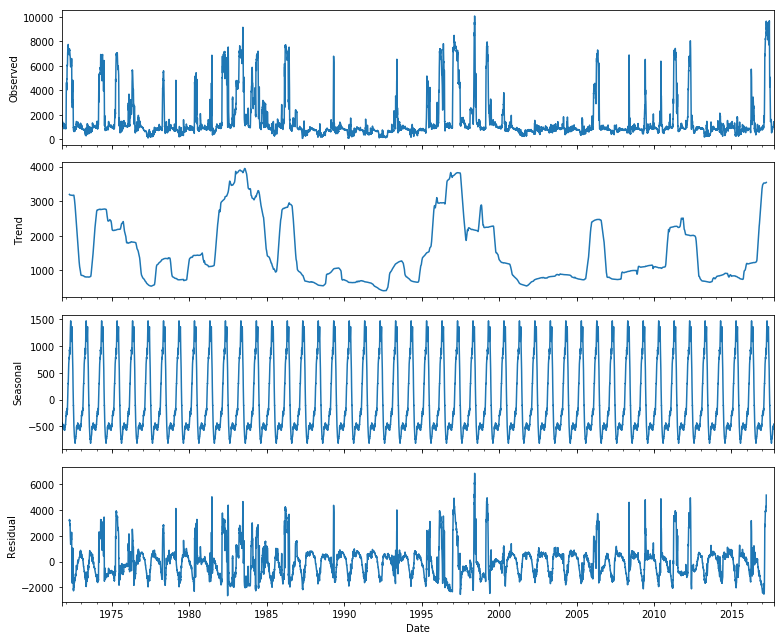

In [48]:
# Decomposition of the data
# Lucky Peak
# Decomposition
rcParams['figure.figsize'] = 11, 9
print('Decomposition of Lucky Peak Discharge')
fig = decompositionLucky.plot()
plt.show()
# Parma
# Decomposition
rcParams['figure.figsize'] = 11, 9
print('Decomposition of Parma Discharge')
fig2 = decompositionParma.plot()
plt.show()

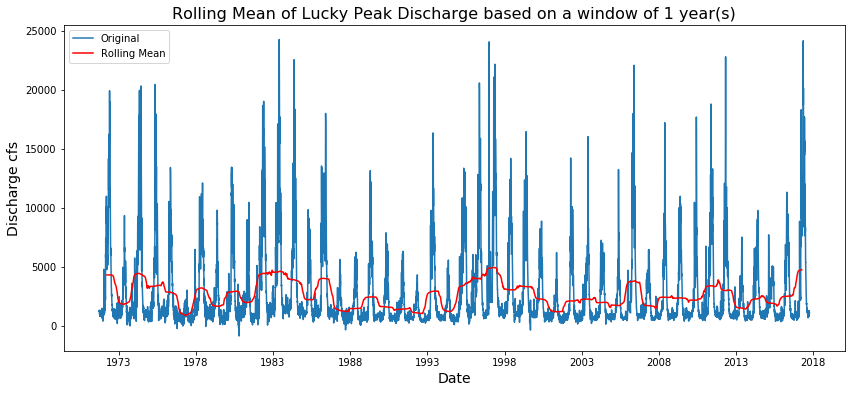

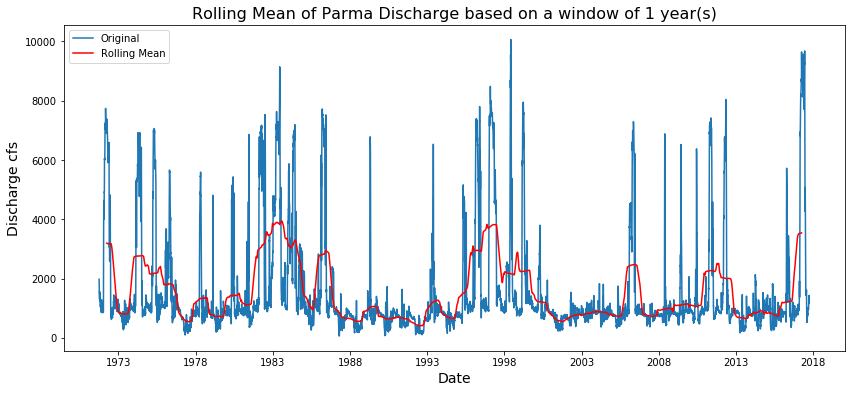

In [49]:
# Variables for moving averages
rolmean_lucky = pd.rolling_mean(seriesLucky, window=years, center=True)
rolstd_lucky = pd.rolling_std(seriesLucky, window=years, center=True)
rolmean_parma = pd.rolling_mean(seriesParma, window=years, center=True)
rolstd_parma = pd.rolling_std(seriesParma, window=years, center=True)
RM_Lucky = pd.rolling_mean(seriesLucky, window=years, center=True).values
RM_Parma = pd.rolling_mean(seriesParma, window=years, center=True).values

# Plot Lucky Peak
plt.figure(figsize=(14,6))
orig = plt.plot(seriesLucky,label='Original')
mean = plt.plot(rolmean_lucky, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean of Lucky Peak Discharge based on a window of %i year(s)'%N,fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()

# Plot Parma
plt.figure(figsize=(14,6))
orig = plt.plot(seriesParma,label='Original')
mean = plt.plot(rolmean_parma, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean of Parma Discharge based on a window of %i year(s)'%N,fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()

### Clean modeled data

In [50]:
# Create new dataframe and remove NaN values from the data
df2 = pd.DataFrame({'Date': dates, 'RM_lucky': RM_Lucky, 'RM_Parma': RM_Parma})
filtered_df2 = df2[df2['RM_lucky'].notnull()]
RM_Lucky_f = filtered_df2['RM_lucky'].values
RM_Parma_f = filtered_df2['RM_Parma'].values
date_f = filtered_df2['Date'].values.astype('datetime64[D]')

# Calculate the difference per year between the datasets
# Difference
difference = []
for i in range(len(RM_Lucky_f)):
    x = RM_Lucky_f[i] - RM_Parma_f[i]
    difference.append(x)
difference = np.array(difference)

# trendline psuedo x vector    
daterange = np.arange(0,len(difference),1)

## Lucky Peak trends
- Observed data and Moving Average data

Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.
Trend Hypothesis = down
Trend result: Downward trend
Level of significance: 0.05
Confidence level: 0.95
P-value : 0.0000000000000843


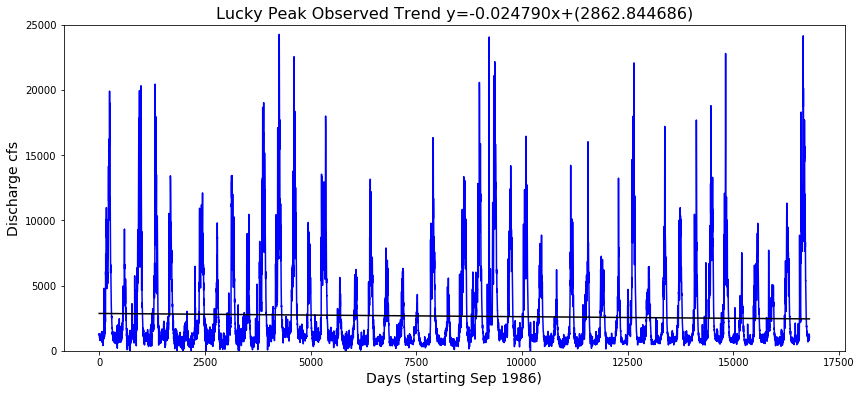

In [51]:
# Trend analysis on Observed (nonparametric) values
# trendline xy vector  s  
daterange = np.arange(0,len(lucky),1)
lucky = np.array(lucky)
# Mann-Kendall
MK, m, c, p, alpha, Ha, con = test(daterange, lucky, eps=1, alpha=0.05, Ha="down");
print('Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.')
print('Trend Hypothesis = %s'%Ha)
print('Trend result: %s'%MK)
print('Level of significance: %.2f'%alpha)
print('Confidence level: %.2f'%con)
print('P-value : %.16f'%p)

# Plot of Lucky peak observed values trend
zl = np.polyfit(daterange, lucky, 1)
pl = np.poly1d(zl)
# Plot
plt.figure(figsize=(14,6))
plt.plot(daterange,lucky,color="blue")
plt.plot(daterange,pl(daterange),color="black")
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
plt.title('Lucky Peak Observed Trend y=%.6fx+(%.6f)'%(zl[0],zl[1]), fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,25000])
plt.show()

Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.
Trend Hypothesis = down
Trend result: Downward trend
Level of significance: 0.05
Confidence level: 0.95
P-value : 0.0000000000000000


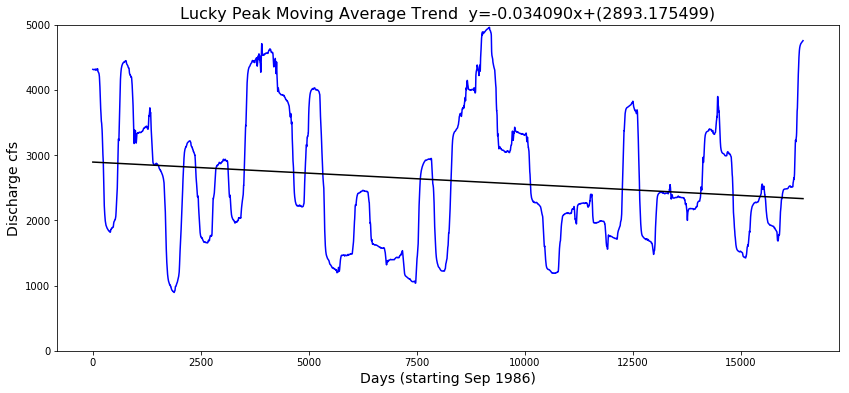

In [52]:
# Trend analysis on Moving Average (parametric) values
# trendline xy vector  s  
daterange = np.arange(0,len(date_f),1)
RM_Lucky_f = np.array(RM_Lucky_f)
# Mann-Kendall
MK, m, c, p, alpha, Ha, con = test(daterange, RM_Lucky_f, eps=0.01, alpha=0.05, Ha="down");
print('Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.')
print('Trend Hypothesis = %s'%Ha)
print('Trend result: %s'%MK)
print('Level of significance: %.2f'%alpha)
print('Confidence level: %.2f'%con)
print('P-value : %.16f'%p)

# Plot of Lucky peak observed values trend
daterange = np.arange(0,len(RM_Lucky_f),1)
zl = np.polyfit(daterange, RM_Lucky_f, 1)
pl = np.poly1d(zl)
# Plot
plt.figure(figsize=(14,6))
plt.plot(daterange,RM_Lucky_f,color="blue")
plt.plot(daterange,pl(daterange),color="black")
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
plt.title('Lucky Peak Moving Average Trend  y=%.6fx+(%.6f)'%(zl[0],zl[1]), fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,5000])
plt.show()

# Linear Regression tbd


## Parma trends
- Observed data and Moving Average data

Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.
Trend Hypothesis = down
Trend result: Downward trend
Level of significance: 0.05
Confidence level: 0.95
P-value : 0.0000000000000000


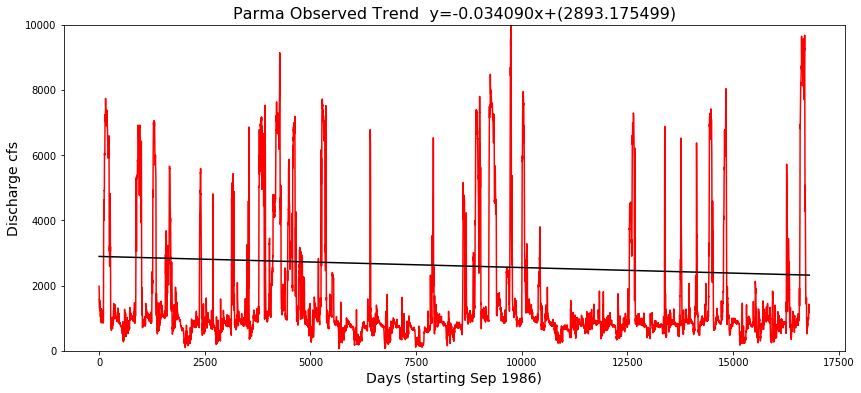

In [58]:
# Trend analysis on Observed (nonparametric) values
# trendline xy vector  s  
daterange = np.arange(0,len(parma),1)
parma = np.array(parma)
# Mann-Kendall
MK, m, c, p, alpha, Ha, con = test(daterange, parma, eps=0.01, alpha=0.05, Ha="down");
print('Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.')
print('Trend Hypothesis = %s'%Ha)
print('Trend result: %s'%MK)
print('Level of significance: %.2f'%alpha)
print('Confidence level: %.2f'%con)
print('P-value : %.16f'%p)

# Plot of parma observed values trend
zp = np.polyfit(daterange, parma, 1)
pp = np.poly1d(zl)
# Plot
plt.figure(figsize=(14,6))
plt.plot(daterange,parma,color="red")
plt.plot(daterange,pp(daterange),color="black")
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
plt.title('Parma Observed Trend  y=%.6fx+(%.6f)'%(zl[0],zl[1]), fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,10000])
plt.show()

Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.
Trend Hypothesis = down
Trend result: Downward trend
Level of significance: 0.05
Confidence level: 0.95
P-value : 0.0000000000000000


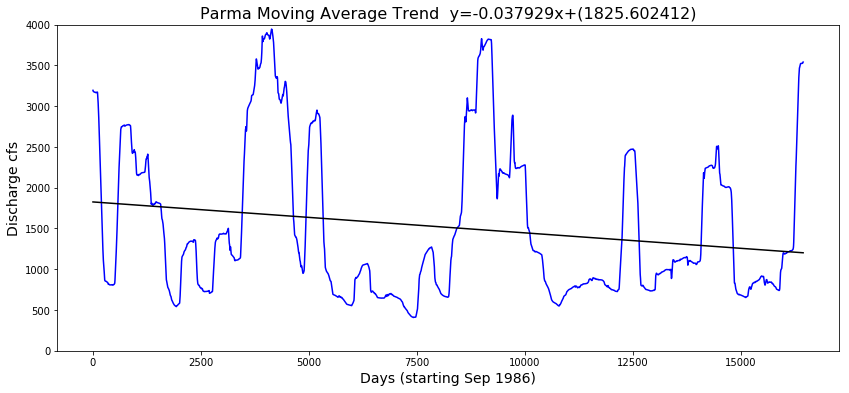

In [54]:
# Trend analysis on Moving Average (parametric) values
# trendline xy vector  s  
daterange = np.arange(0,len(date_f),1)
RM_Parma_f = np.array(RM_Parma_f)

# Mann-Kendall
MK, m, c, p, alpha, Ha, con = test(daterange[0:16000], RM_Parma_f[0:16000], eps=0.01, alpha=0.05, Ha="down");
print('Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.')
print('Trend Hypothesis = %s'%Ha)
print('Trend result: %s'%MK)
print('Level of significance: %.2f'%alpha)
print('Confidence level: %.2f'%con)
print('P-value : %.16f'%p)

# Plot of Lucky peak observed values trend
daterange = np.arange(0,len(RM_Parma_f),1)
zl = np.polyfit(daterange, RM_Parma_f, 1)
pl = np.poly1d(zl)
# Plot
plt.figure(figsize=(14,6))
plt.plot(daterange,RM_Parma_f,color="blue")
plt.plot(daterange,pl(daterange),color="black")
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
plt.title('Parma Moving Average Trend  y=%.6fx+(%.6f)'%(zl[0],zl[1]), fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,4000])
plt.show()

# Linear Regression tbd

## Lucky Peak, Parma, and their Difference
- Observed data and Moving Average data

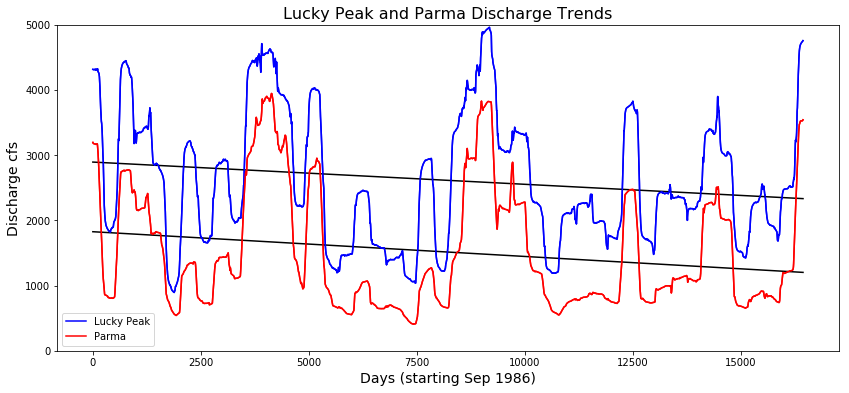

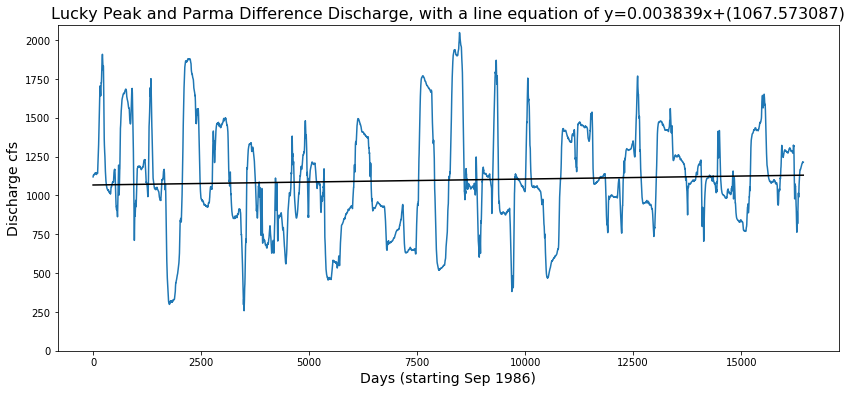

Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.
Trend Hypothesis = up
Trend result: Upward trend
Level of significance: 0.05
Confidence level: 0.95
P-value : 0.0000000000002778
Percent Change of trendline: 5.74 percent


In [75]:
# Calculate the difference per year between the datasets
difference = []
for i in range(len(RM_Lucky_f)):
    x = RM_Lucky_f[i] - RM_Parma_f[i]
    difference.append(x)
difference = np.array(difference)
# trendline x vector    
daterange = np.arange(0,len(difference),1)

# Plot of both Lucky peak and Parma
# lucky peak trendline
zl = np.polyfit(daterange, RM_Lucky_f, 1)
pl = np.poly1d(zl)
# Parma trendline
zp = np.polyfit(daterange, RM_Parma_f, 1)
pp = np.poly1d(zp)
# Plot
plt.figure(figsize=(14,6))
plt.plot(daterange,RM_Lucky_f,color="blue")
plt.plot(daterange,pl(daterange),color="black")
plt.plot(daterange,RM_Parma_f,color="red")
plt.plot(daterange,pp(daterange),color="black")
orig = plt.plot(RM_Lucky_f,label='Lucky Peak',color="blue")
mean = plt.plot(RM_Parma_f, color='red', label='Parma')
plt.legend(loc='best')
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
plt.title('Lucky Peak and Parma Discharge Trends', fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,5000])
plt.show()

# Plot difference of both moving averages
# difference trendline
z1 = np.polyfit(daterange, difference, 1)
p1 = np.poly1d(z1)
dp = p
plt.figure(figsize=(14,6))
plt.plot(daterange,difference)
plt.plot(daterange,p1(daterange),color="black")
plt.title('Lucky Peak and Parma Difference Discharge, with a line equation of y=%.6fx+(%.6f)'%(z[0],z[1]),fontsize=16)
plt.ylabel('Discharge cfs',fontsize=14)
plt.xlabel('Days (starting Sep 1986)',fontsize=14)
axes = plt.gca()
axes.set_ylim([0,2100])
plt.show()

# trendline values
trendline = []
for i in range(len(difference)):
    x = 0.003839*daterange[i]+(1067.573087)
    trendline.append(x)
trendline = np.array(trendline)
df_diff = pd.DataFrame({'Trend':trendline,'Days':daterange})
seriesTrend = pd.Series(df_diff['Trend'].values,df_diff['Days'].values)
pc = seriesTrend.pct_change()
pcsum = sum(pc[1:])*100 # total percent change of trendline over time

# confidence interval
ci = mean_confidence_interval(difference, confidence=0.95)
# Mann-Kendall on Difference data
MK, m, c, p, alpha, Ha, con = test(daterange[0:16000], difference[0:16000], eps=.01, alpha=0.05, Ha="up");
print('Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.')
print('Trend Hypothesis = %s'%Ha)
print('Trend result: %s'%MK)
print('Level of significance: %.2f'%alpha)
print('Confidence level: %.2f'%con)
print('P-value : %.16f'%p)
print('Percent Change of trendline: %.2f percent'%pcsum)

### Boise Temperature Trend

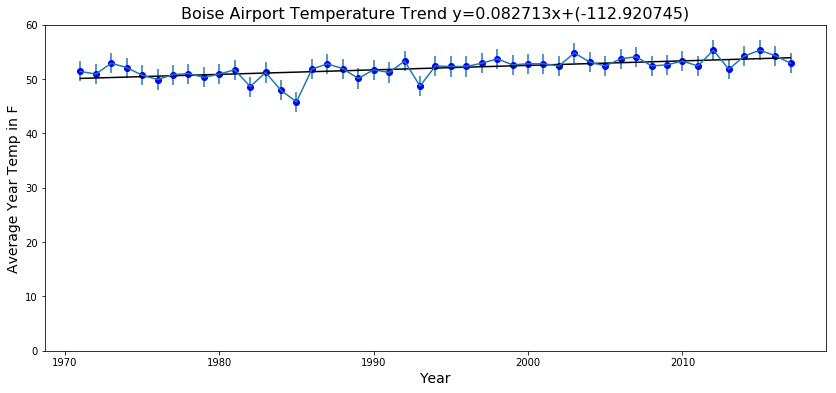

Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.
Trend Hypothesis = up
Trend result: Upward trend
Level of significance: 0.05
Confidence level: 0.95
P-value : 0.0000002540705359
Confidence Interval and Range
(52.008510638297885, 51.464948151276197, 52.552073125319573)
Percent Change of trendline: 7.32 percent


In [89]:
# Boise Historically temperatures reported from the Airport weather station since 1971
tempValues = df2['TEMP'].values
tempYear = df2['YEAR'].values
seriesTemp = pd.Series(tempValues,tempYear)

# Confidence Interval
ci = mean_confidence_interval(tempValues, confidence=0.95)

# Plot of Boise Airport observed values trend
daterange = tempYear
zl = np.polyfit(daterange, tempValues, 1)
pl = np.poly1d(zl)

# error bar values
yerrTemp = statistics.stdev(tempValues)

# Plot
plt.figure(figsize=(14,6))
plt.plot(daterange,tempValues,'o',color="blue")
plt.plot(daterange,pl(daterange),color="black")
plt.xlabel('Year',fontsize=14)
plt.title('Boise Airport Temperature Trend y=%.6fx+(%.6f)'%(zl[0],zl[1]), fontsize=16)
plt.ylabel('Average Year Temp in F',fontsize=14)
plt.errorbar(daterange,tempValues,yerr=yerrTemp)
axes = plt.gca()
axes.set_ylim([0,60])
plt.show()

# trendline values
trendlineTemp = []
for i in range(len(tempValues)):
    x = 0.082713*daterange[i]+(-112.920745)
    trendlineTemp.append(x)
trendlineTemp = np.array(trendlineTemp)
df_temp = pd.DataFrame({'Trend':trendlineTemp,'Days':daterange})
seriesTrendTemp = pd.Series(df_temp['Trend'].values,df_temp['Days'].values)
pc = seriesTrendTemp.pct_change()
pcsum = sum(pc[1:])*100 # total percent change of trendline over time

# Confidence Interval
ci = mean_confidence_interval(tempValues, confidence=0.95)
# Mann-Kendall on Temp data
MK, m, c, p, alpha, Ha, con = test(tempYear, tempValues, eps=.01, alpha=0.05, Ha="up");
print('Explanation: If your significance level is 0.05, the corresponding confidence level is 95%. If the P-value is less than your significance level, the hypothesis test is statistically significant.')
print('Trend Hypothesis = %s'%Ha)
print('Trend result: %s'%MK)
print('Level of significance: %.2f'%alpha)
print('Confidence level: %.2f'%con)
print('P-value : %.16f'%p)
print('Confidence Interval and Range')
print(ci)
print('Percent Change of trendline: %.2f percent'%pcsum)

## Analysis of Twin Springs Discharge and Temperature data

## Results
The trend test models show the trend to be increasing within the Difference data. That is to say-
there is a small, but increasing trend in the difference of water entering the lower basin system
from Lucky Peak, and the water leaving the system at Parma. Or- less and less water is leaving
the lower basin system at Parma over time. Given there is a significant upward trend in the mean temperature of the valley, you could say they are somewhat correlated.